# 2. train model

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 2.1 load and inpsect data

In [33]:
X_train = np.load("../data/X_train.npy")
y_train = np.load("../data/y_train.npy")

X_val = np.load("../data/X_val.npy")
y_val = np.load("../data/y_val.npy")

X_test = np.load("../data/X_test.npy")
y_test = np.load("../data/y_test.npy")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (294359, 12, 13)
y_train shape: (294359, 13)


## 2.2 train the model

In [34]:
model = Sequential([
    Input(shape=(12, 13)), # 12 time steps with 13 features each
    LSTM(
        64, # 64 neurons
        return_sequences=False # predict only one step ahead
    ),
    Dropout(0.2), # randomly turn off 20% neurons during training to reduce overfitting
    Dense(32, activation='relu'), # intermediate layer
    Dense(13)  # output 13 predicted features
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,477 (87.80 KB)

 Trainable params: 22,477 (87.80 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
optimizer = Adam( # 
    learning_rate=0.001 # how big a step the optimizer takes in each weight update
)
model.compile(
    optimizer=optimizer, 
    loss='mse', # mean square error for calculating loss function - model trains on it
    metrics=['mae'] # mean absolute error for evaluation - easier to interpret
)

In [36]:
history = model.fit(
    X_train, y_train, # training input and targets
    validation_data=(X_val, y_val), # validation input and targets to avoid overfitting
    epochs=5, # no of epochs
    batch_size=64, # batch size
    verbose=1 # for monitoring progress
)

model.save("../models/lstm_weather.keras")

Epoch 1/5
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 119s 25ms/step - loss: 0.0036 - mae: 0.0302 - val_loss: 0.0022 - val_mae: 0.0169
Epoch 2/5
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - loss: 0.0024 - mae: 0.0219 - val_loss: 0.0022 - val_mae: 0.0161
Epoch 3/5
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - loss: 0.0022 - mae: 0.0201 - val_loss: 0.0024 - val_mae: 0.0211
Epoch 4/5
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 98s 21ms/step - loss: 0.0022 - mae: 0.0190 - val_loss: 0.0027 - val_mae: 0.0266
Epoch 5/5
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 100s 22ms/step - loss: 0.0021 - mae: 0.0183 - val_loss: 0.0030 - val_mae: 0.0300


## 2.3 plot loss curves

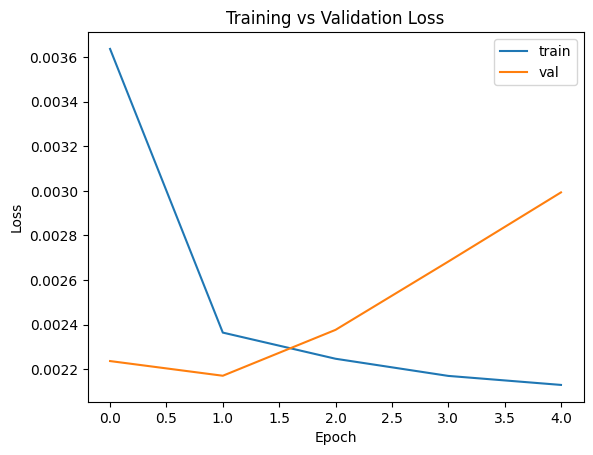

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

## 2.4 evaluate on test set 

In [38]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MAE:", test_mae)

1971/1971 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0025 - mae: 0.0271
Test MAE: 0.027091901749372482


1971/1971 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


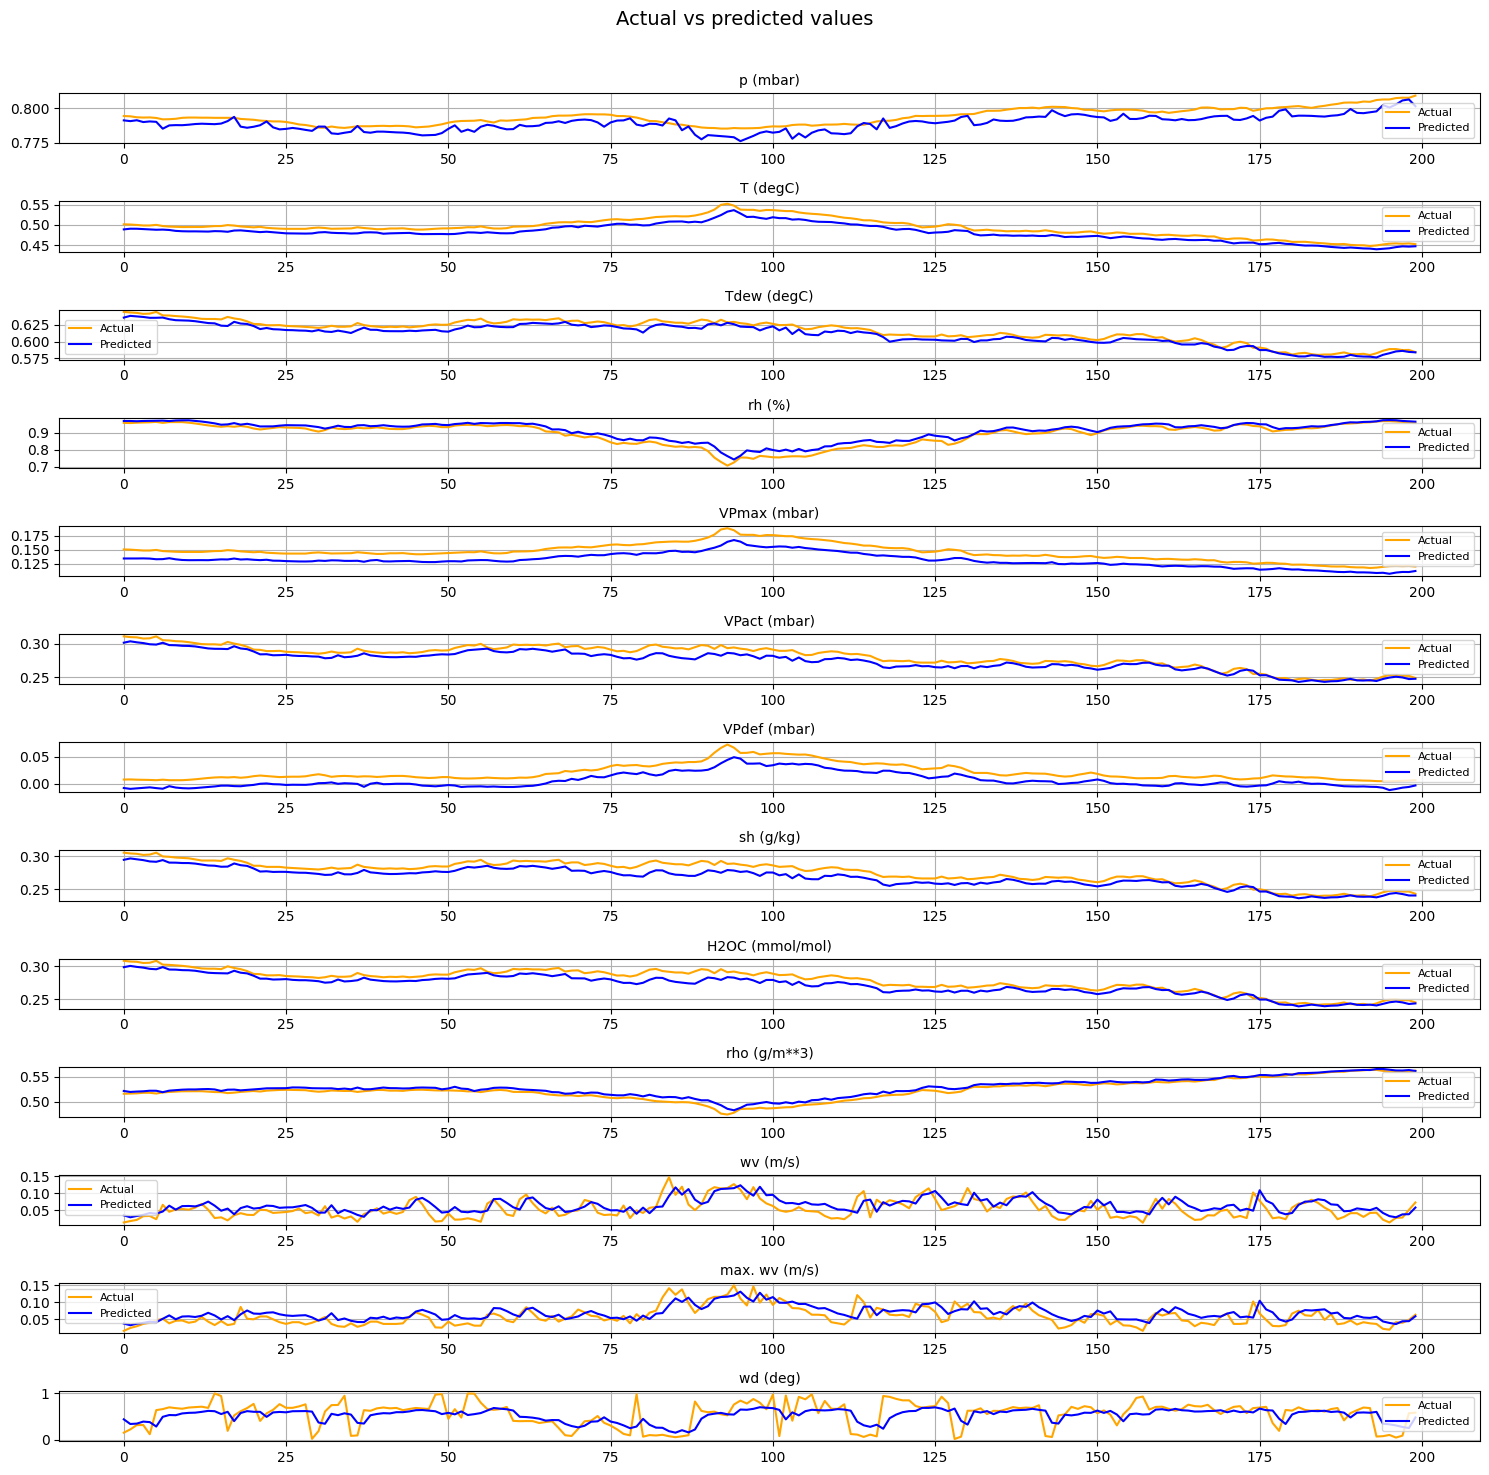

In [40]:
y_pred = model.predict(X_test)

NUMERIC_COLS = [
    "p (mbar)",
    "T (degC)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)"
]

n_features = len(NUMERIC_COLS)
n_rows, n_cols = 13, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

for i in range(n_features):
    ax = axes[i]
    ax.plot(y_test[:200, i], label="Actual", color='orange')
    ax.plot(y_pred[:200, i], label="Predicted", color='blue')
    ax.set_title(NUMERIC_COLS[i], fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True)

fig.suptitle("Actual vs predicted values", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [30]:
import numpy as np

# shapes
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_val", X_val.shape, "y_val", y_val.shape)
print("X_test", X_test.shape, "y_test", y_test.shape)

# basic stats per set (flatten last feature axis)
def stats(arr, name):
    a = arr.reshape(-1, arr.shape[-1])
    print(name, "min", np.min(a, axis=0))
    print(name, "max", np.max(a, axis=0))
    print(name, "mean", np.mean(a, axis=0))
    print(name, "std", np.std(a, axis=0))
    print()

# For X (3D) and y (2D or 3D), adapt:
stats(X_train, "X_train")
stats(X_val, "X_val")

# y may be (N,13) or (N,1,13); make compatible
ytr = y_train.reshape(y_train.shape[0], y_train.shape[-1])
yva = y_val.reshape(y_val.shape[0], y_val.shape[-1])
yte = y_test.reshape(y_test.shape[0], y_test.shape[-1])
stats(ytr, "y_train")
stats(yva, "y_val")
stats(yte, "y_test")


X_train (294373, 12, 13) y_train (294373, 13)
X_val (63071, 12, 13) y_val (63071, 13)
X_test (63071, 12, 13) y_test (63071, 13)
X_train min [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_train max [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
X_train mean [0.75630913 0.54557156 0.61531043 0.72318572 0.21360984 0.31117101
 0.09491222 0.30704861 0.30927675 0.47156719 0.14727398 0.15152265
 0.48178028]
X_train std [0.08360433 0.14700259 0.1448988  0.19020094 0.13247357 0.15287296
 0.11432669 0.15153065 0.15204954 0.12258822 0.10458767 0.09847597
 0.2435408 ]

X_val min [ 3.22853688e-01  2.49532869e-01  2.86159601e-01  1.37851809e-01
  3.97795764e-02  6.50199782e-02  0.00000000e+00  6.35280771e-02
  6.38829408e-02  1.24577210e-01 -6.83458647e+02 -4.25489362e+02
  0.00000000e+00]
X_val max [1.01108424 1.02412094 0.94742311 1.         1.08179783 0.853251
 1.09235518 0.84685196 0.84867951 0.74444012 1.94736842 0.89319149
 1.        ]
X_val mean [ 0.77176498  0.57692312  0.65055398  0.71872279  0.23718

In [31]:
import pandas as pd
pd.options.display.max_columns = 30

val_raw = pd.read_csv("../data/validation_set.csv", header=0)
# show top rows
print(val_raw.head())

# quick describe (raw)
print(val_raw[NUMERIC_COLS].describe().T)

# check dtypes and non-numeric entries (will coerce bad -> NaN)
for col in NUMERIC_COLS:
    s = pd.to_numeric(val_raw[col], errors='coerce')
    n_bad = s.isna().sum()
    mn = s.min()
    mx = s.max()
    print(col, "dtype:", val_raw[col].dtype, "bad:", n_bad, "min:", mn, "max:", mx)

             Date Time  p (mbar)  T (degC)  Tdew (degC)  rh (%)  VPmax (mbar)  \
0  05.08.2014 02:30:00    990.39     14.10        13.44    95.8         16.11   
1  05.08.2014 02:40:00    990.41     13.97        13.36    96.1         15.98   
2  05.08.2014 02:50:00    990.49     13.75        13.17    96.3         15.75   
3  05.08.2014 03:00:00    990.64     13.70        13.20    96.8         15.70   
4  05.08.2014 03:10:00    990.66     13.83        13.39    97.2         15.83   

   VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
0         15.44          0.68       9.75            15.59       1193.97   
1         15.35          0.62       9.70            15.50       1194.57   
2         15.17          0.58       9.58            15.31       1195.67   
3         15.20          0.50       9.60            15.34       1196.05   
4         15.39          0.44       9.72            15.53       1195.44   

   wv (m/s)  max. wv (m/s)  wd (deg)  
0      1.29           2